## Introduction

As a business that buys and sells used books, we rely on accurate and standardized book information to keep things running smoothly. Over time, we've sourced books from various partners, each with its own way of recording book details.

In many cases, crucial information like author names, publishers, or release years is missing or incomplete. To make matters worse, some of the older, quirky systems used by our partners enforce a 40-character limit for book details, resulting in truncated and inconsistent records. This has led to situations where the same book ends up with multiple conflicting records in our database. With thousands of books coming in every month, our team has been manually searching the internet to fill in the gaps—a time-consuming and tedious task.

We needed a smarter, faster way to clean up and enrich our database, ideally reducing 80% of the manual effort for our employees. In this case study, I’ll share how I built a system to automate the enrichment process using web crawling and AI-powered information extraction. The solution leverages search engines to find relevant data and uses LLMs to parse and structure the information, enabling us to standardize records more efficiently. Our team can now focus on filling in just the final details to make the data complete.

## Overall Solution

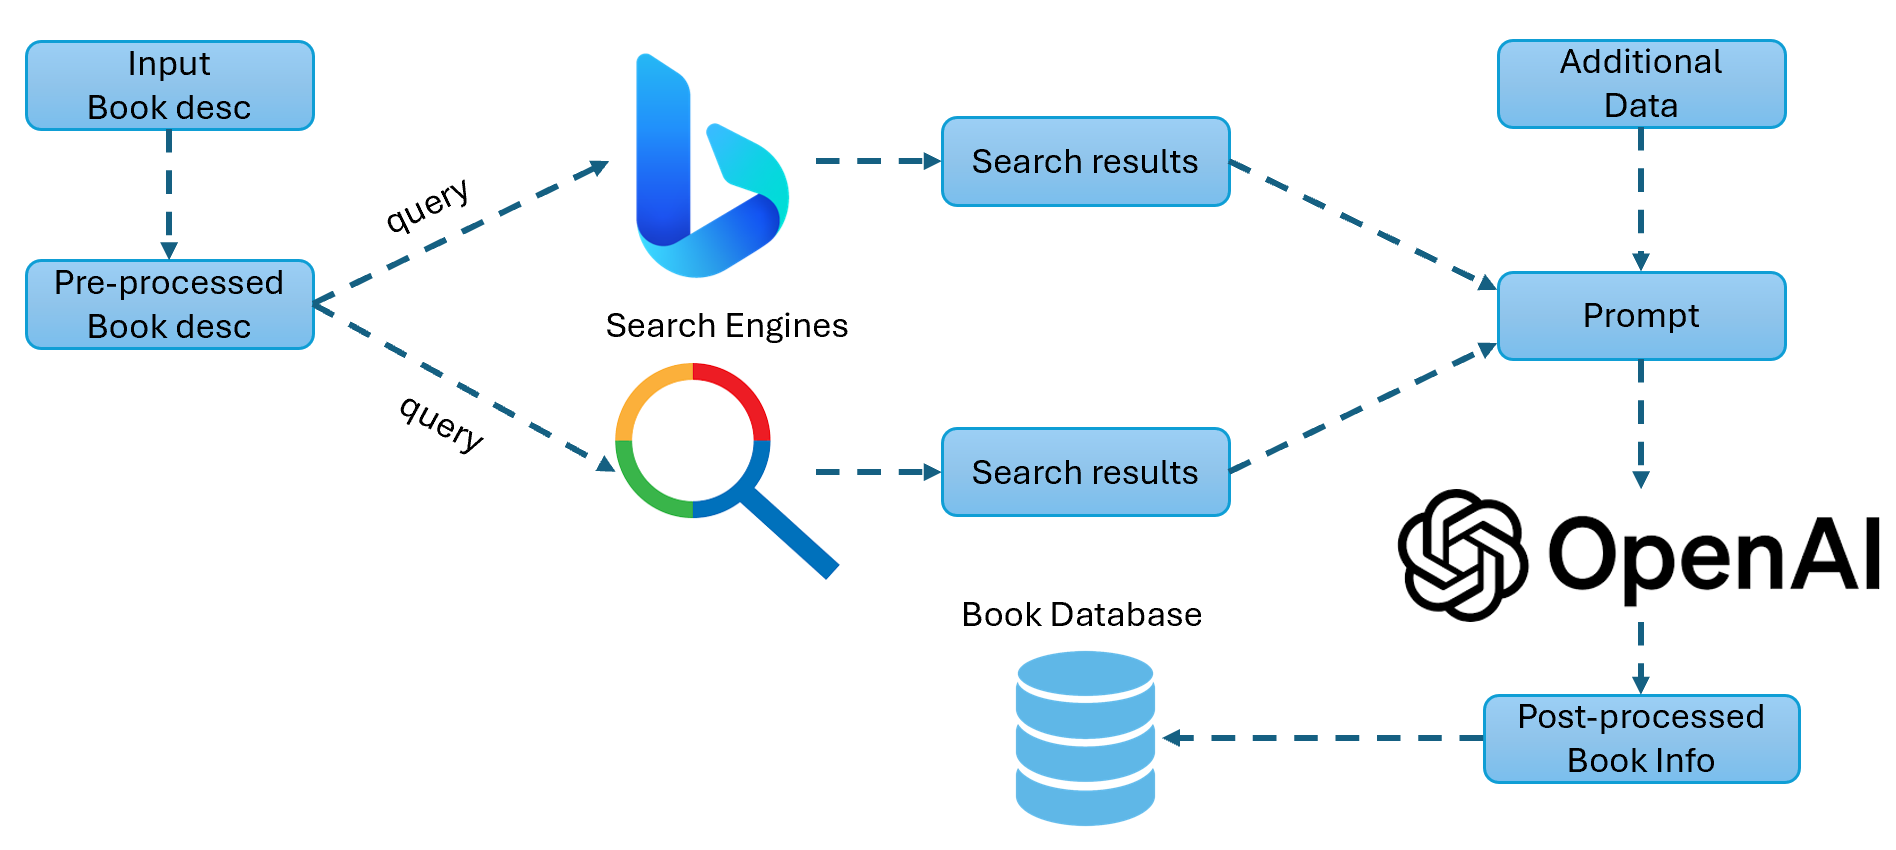

- Clean up the book description
- Search the web for relevant book results
- Create a prompt by combining search results and extra data
- Use OpenAI to extract book information with the prompt
- Post-process and store the book information into a database

## Necessary Packages

In [16]:
# %pip install openai
# !pip install python-dotenv

In [17]:
import pandas as pd
from openai import OpenAI
import requests
import os
from dotenv import load_dotenv

## Data Understanding

In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# project_folder = '/content/drive/MyDrive/Colab Notebooks/2025.01.22 Book Info Enrichment'
# data_book = pd.read_csv(f"{project_folder}/dataset/books.csv")
# data_genre = pd.read_csv(f"{project_folder}/dataset/genres.csv")
data_book = pd.read_csv(f"dataset/books.csv")
data_genre = pd.read_csv(f"dataset/genres.csv")

genres = ','.join(data_genre['genre'].astype(str))
print(genres)
data_book.head(10)

Action,Biography & Autobiography,Business & Economics,Computers,Design,Education,Family & Relationships,History,Horror,Juvenile Fiction,Juvenile Nonfiction,Law,Military,Mind & Spirit,Music,Political Science,Psychology,Religion,Science,Self-Help,Social Science,Technology & Engineering,Young Adult Fiction


,book_info
0,"The 7 Habits,Stephen,Simon,391"
1,"Mockingjay,Suzanne C,Scholastic"
2,"Command Nuclear,E Schlosser,2014,Penguin"
3,"Defending Castle,Chicago,Science, 2014"
4,"Fighter Planes, Zuehlke, 0.15 lbs,Ahead"
5,"Knit Kimono, Square,0.8 in,Interweave"
6,"French Kids,Le Billon,Hardcover,2014"
7,"Beginner Day Trading, T Turner,Business"
8,"40-Day Social,Speake,9780801094583"
9,"Shallows Internet,N Carr,Computers"


## Setup

In [20]:
# load_dotenv(f"{project_folder}/.env")
load_dotenv(".env")
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_SEARCH_API_KEY")
search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")
bing_api_key = os.getenv("BING_SEARCH_API_KEY")
num_results = 5

- Do not turn on "SafeSearch".
- Turn off "Search the entire web".

## Cleaning Up the Book Description

Since our solution relies on web searches and a Large Language Model (LLM), the quality of the search query is crucial. The goal is to strip down the messy book descriptions and keep only the key details needed to find the right book. Anything irrelevant or distracting gets removed:
- Weight, dimensions, and cover type - these don't help in identifying the book.
- Number of pages - gone, but we keep the publication year.
- Commas - yep, they're out too, not helpful for searching.

In [21]:
import re

def clean_book_info(book_string):
    # Remove weight (with lbs)
    book_string = re.sub(r'\d+\.?\d* lbs', '', book_string)

    # Remove dimensions (with in)
    book_string = re.sub(r'\d+\.?\d* in', '', book_string)

    # Remove cover types
    book_string = re.sub(r'(Hardcover|Paperback)', '', book_string, flags=re.IGNORECASE)

    # Remove page numbers between 100 and 800
    book_string = re.sub(r'\b([1-7]\d{2}|800)\b', '', book_string)

    # Remove (ISBN) numbers > 3000
    book_string = re.sub(r'\b[3-9]\d{3,}|\d{5,}\b', '', book_string)

    # Remove extra commas
    book_string = re.sub(r',\s*,', ',', book_string)

    # Remove commas
    book_string = re.sub(', ', ' ', book_string)
    book_string = re.sub(',', ' ', book_string)

    # Trim leading and trailing whitespace and commas
    book_string = book_string.strip(' ,')

    book_string = re.sub('  ', ' ', book_string)

    return book_string

# Test the function with provided samples
samples = [
    'Fighter Planes, J Zuehlke, 0.15 lbs,2005',
    'Knit Kimono, Square,0.8 in,Interweave',
    'French Kids,Le Billon,Hardcover,2014',
    'The 7 Habits,Stephen,Simon,391'
]

for sample in samples:
    print(f"Original: {sample}")
    print(f"Cleaned:  {clean_book_info(sample)}")
    print()

Original: Fighter Planes, J Zuehlke, 0.15 lbs,2005
Cleaned:  Fighter Planes J Zuehlke 2005

Original: Knit Kimono, Square,0.8 in,Interweave
Cleaned:  Knit Kimono Square Interweave

Original: French Kids,Le Billon,Hardcover,2014
Cleaned:  French Kids Le Billon 2014

Original: The 7 Habits,Stephen,Simon,391
Cleaned:  The 7 Habits Stephen Simon



## Searching with Book Description
Once we have a cleaned-up book description, we run a search on both Google and Bing, grabbing the top 5 results from each.

In [22]:
from datetime import datetime
import json

def google_search(query):
    """
    Perform a Google Custom Search API query and return top 3 result snippets.

    Parameters:
    - query (str): Search query string

    Returns:
    - list: A list of 3 dictionaries containing search result snippets
    """
    # Prepare the API endpoint URL
    base_url = "https://www.googleapis.com/customsearch/v1"

    # Parameters for the API request
    params = {
        'key': google_api_key,
        'cx': search_engine_id,
        'q': query,
        'num': num_results  # Limit to 3 results
    }

    try:
        response = requests.get(base_url, params=params)

        # Check if the request was successful
        response.raise_for_status()

        # Parse the JSON response
        search_results = response.json()

        # Extract snippets from the results
        snippets = []
        for item in search_results.get('items', []):
            snippet_info = {
                'title': item.get('title', 'No Title'),
                'link': item.get('link', 'No Link'),
                'snippet': item.get('snippet', 'No Snippet')
            }
            snippets.append(snippet_info)
        return snippets

    except requests.RequestException as e:
        print(f"Error making Google Search API request: {e}")
        return []
    except KeyError as e:
        print(f"Error parsing search results: {e}")
        return []


In [23]:
def bing_search(query):
    """
    Perform a Bing Web Search using the Bing Search API
    Args:
        query (str): Search query
    Returns:
        list: Search results containing title, link, and snippet
    """
    endpoint = "https://api.bing.microsoft.com/v7.0/search"

    headers = {
        "Ocp-Apim-Subscription-Key": bing_api_key
    }

    params = {
        "q": query,
        "count": num_results
    }

    try:
        response = requests.get(endpoint, headers=headers, params=params)
        response.raise_for_status()

        search_results = response.json()

        # Extract relevant information from search results
        results = []
        for item in search_results.get('webPages', {}).get('value', []):
            result = {
                'title': item.get('name', 'No Title'),
                'link': item.get('url', 'No Link'),
                'snippet': item.get('snippet', 'No Snippet')
            }
            results.append(result)

        return results

    except requests.RequestException as e:
        print(f"Search API request failed: {e}")
        return []
    except KeyError as e:
        print(f"Search results parsing failed: {e}")
        return []

## Extracting Book Information
Now, here's the prompt we use for OpenAI. I pass in 3 variables
- `search_results`: Combined titles and snippets from Google & Bing
- `keywords`: Our cleaned-up book description
- `keywords.split(' ')[0]`: First word of the book description which normally part of the book title
- `genres`: A predefined list of book genres from our system

In [24]:
def extract_book_info(search_results, keywords):
    """
    Use OpenAI to extract book information from search results
    """
    client = OpenAI(api_key=openai_api_key)

    # Construct prompt with search results
    prompt = f"""
    From below search results, please extract book title, author, genre, publication year, ISBN, and publisher.
    If you could not find the information, please leave it blank.

    {search_results}

    The correct book must have most of following keywords: {keywords}
    - Title of the book must have this word: {keywords.split(' ')[0]}
    - Author of the book can be found after "Author" or "by"
    - Publisher of the book can be found after "Publisher" or "Published by"
    - Genre of the book can be found after "Genre" and can be one of the following: {genres}
    - Year of the book can be found after "Year", "Date", "Publication" or "Published"
    - ISBN of the book is a number of 10 or 13 digits and can be found after "ISBN"
    Provide the information of book title, author, genre, year, ISBN, and publisher in this JSON format:
    {{
        "Title": "...",
        "Author": "...",
        "Publisher": "...",
        "Genre": "...",
        "Year": "...",
        "ISBN": "..."
    }}
    """

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful book information extraction assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            response_format={"type": "json_object"}
        )
        # print(f"prompt {prompt}")
        return completion.choices[0].message.content

    except Exception as e:
        print(f"Error in OpenAI API call: {e}")
        return None

Bing's snippets is longer and more informative than Google's, so I use Bing as the main source and Google as a backup. If Google finds the same book but has extra details, I merge that info into the final dataframe.

In [25]:
import difflib

def update_book_record(main_df, sup_df):
    """
    Compare and update book record if titles are similar

    Args:
        main_df (pd.DataFrame): Main book DataFrame
        supplementary_df (pd.DataFrame): Google search result DataFrame

    Returns:
        pd.DataFrame: Updated main DataFrame
    """
    # Get last row of main DataFrame
    main_row = main_df.iloc[-1]

    # Get Google search result row
    sup_row = sup_df.iloc[0]

    # Check title similarity
    similarity = difflib.SequenceMatcher(
        None,
        str(main_row['Title']).lower(),
        str(sup_row['Title']).lower()
    ).ratio()

    is_substring = str(main_row['Title']).lower() in str(sup_row['Title']).lower() or \
      str(sup_row['Title']).lower() in str(main_row['Title']).lower() or main_row['Title'] == ''
    # Update if title similarity is high
    if is_substring or similarity > 0.5:
        for col in main_df.columns:
            if main_row[col] == '' and sup_row[col]:
                main_df.at[main_df.index[-1], col] = sup_row[col]
                print(f"  Update {col} of {sup_row[col]}")

    return main_df

2 search engines have different top results, so instead of using just one engine, I use Bing as the main one and Google as the one to complete the book info if it find information that Bing does not.

Amazon the largest site about book does not have info of genre. Old books do not have genre.

Different runs have different results, randomness in search engines to pick top 3 webpages.

In [26]:
book_df = pd.DataFrame(columns=['Title', 'Author', 'Publisher', 'Genre', 'Year', 'ISBN'])
for info in data_book["book_info"]:            # loop = a book
  info = clean_book_info(info)
  query = f"book {info}"
  # Step 1: Perform Bing and Google Searches
  bing_results = bing_search(query)
  google_results = google_search(query)
  search_results = [bing_results, google_results]

  print("\n", query)

  for index, results in enumerate(search_results):  # loop = (B, G) results
    # Prefer Bing than Google, accept Bing results first, use Google to complete
    # Convert search results to a formatted string for the prompt
    results_text = ""
    results_text = "\n".join([
      f"Title: {result['title']}\nSnippet: {result['snippet']}"
      for result in results                         # loop = a web result
    ])

    # Step 2: Extract book information using OpenAI
    book_info = extract_book_info(results_text, info)
    book_dict = json.loads(book_info)
    if index == 0:    # Bing
      book_df = pd.concat([book_df, pd.DataFrame([book_dict])], ignore_index=True)
    elif index == 1:  # Google
      update_book_record(book_df, pd.DataFrame([book_dict]))



 book The 7 Habits Stephen Simon
  Update ISBN of 147112939X

 book Mockingjay Suzanne C Scholastic
  Update ISBN of 9780439023511

 book Command Nuclear E Schlosser 2014 Penguin

 book Defending Castle Chicago Science 2014

 book Fighter Planes Zuehlke Ahead

 book Knit Kimono Square Interweave

 book French Kids Le Billon 2014

 book Beginner Day Trading T Turner Business

 book 40-Day Social Speake

 book Shallows Internet N Carr Computers

 book Harry Potter Hallows Scholastic 2007

 book Diary Girl Frank Random House

 book Music Business Passman 2019 Free
  Update ISBN of 9781501122187

 book Machines Water 2021 B Rossiter

 book eBay Dummies Collier 2006
  Update Publisher of For Dummies

 book Machine Learning M. Mitchell McGraw

 book Deep Learning Goodfellow Courville MIT


In [27]:
book_df

,Title,Author,Publisher,Genre,Year,ISBN
0,The 7 Habits of Highly Effective People,Stephen R. Covey,Simon & Schuster,Self-Help,1989,147112939X
1,Mockingjay: Deluxe Edition,Suzanne Collins,Scholastic,Young Adult Fiction,2010,9780439023511
2,"Command and Control: Nuclear Weapons, the Dama...",Eric Schlosser,Penguin,History,2013,9780143125785
3,"Defending Your Castle: Build Catapults, Crossb...",William Gurstelle,Chicago Review Press,Science,2014,9781613746820
4,Fighter Planes (Pull Ahead Books ― Mighty Movers),Jeffrey Zuehlke,,Juvenile Nonfiction,2005,9780822528739
5,Knit Kimono,Vicki Square,Interweave,,2007,9781931499897
6,French Kids Eat Everything: How Our Family Mov...,Karen Le Billon,,Family & Relationships,2014,
7,A Beginner's Guide to Day Trading Online (2nd ...,Toni Turner,,Business & Economics,2007,
8,The 40-Day Social Media Fast,Wendy Speake,Baker Books,Religion,2020,9781540901194
9,The Shallows: What the Internet Is Doing to Ou...,Nicholas G. Carr,W. W. Norton & Company,Technology & Engineering,2010,


### Find the existing matching book
Even on major websites, book details are often entered inconsistently. Because of these inconsistencies (and the fact that ISBNs aren't always available), the same book can have multiple records in our database. So, before launching a search, I first check if a similar book already exists in our dataset. Below is just a basic example - real-world checks need to account for more variations.

In [28]:
def check_containment(short_string, full_string):
    # Convert both strings to lowercase and split into words
    short_words = set(short_string.strip().replace(':', '').lower().split())
    full_words = set(full_string.strip().replace(':', '').lower().split())

    # Check if all short words are in full string words
    return all(word in full_words for word in short_words)

check_containment("Habits People", "The 7 Habits of Highly Effective People: Power")

True

Increase book count by 1

In [29]:
book_info = "Castle,Gurstelle,2014"

parts = book_info.split(',')
matched_rows = book_df[
    (book_df['Title'].apply(lambda x: check_containment(parts[0], x))) &
     book_df['Author'].apply(lambda x: check_containment(parts[1], x)) |
    (book_df['Title'].apply(lambda x: check_containment(parts[0], x)) &
     book_df['Publisher'].apply(lambda x: check_containment(parts[2], x)))
]
matched_rows

,Title,Author,Publisher,Genre,Year,ISBN
3,"Defending Your Castle: Build Catapults, Crossb...",William Gurstelle,Chicago Review Press,Science,2014,9781613746820


### Filling in missing information

Even after gathering book details, some key pieces of information might still be missing. For example, the extracted results might include a publisher in the title, leave out a genre, or miss the ISBN.

To fill in these gaps, we can run another search using the information we've already found. A refined query could yield different results, helping us retrieve additional details. The process remains the same, so I won't go into it again here.


### Debug a Specific Book Description using Bing

In [30]:
query = "Command Nuclear,Schlosser,2014,Penguin"
query = clean_book_info(query)
# Step 1: Perform a Search
search_results = bing_search("book " + query)
# Print the results
for i, result in enumerate(search_results, 1):
    print(f"Result {i}:")
    print(f"Title: {result['title']}")
    print(f"Link: {result['link']}")
    print(f"Snippet: {result['snippet']}")
    print("-" * 50)

results_text = "\n".join([
  f"Title: {result['title']}\nSnippet: {result['snippet']}"
  for result in search_results
])

# Step 2: Extract book information using OpenAI
book_info = extract_book_info(results_text, clean_book_info(query))

print("\nExtracted Book Information:")
print(book_info)

Result 1:
Title: Command and Control by Eric Schlosser: 9780143125785 ...
Link: https://www.penguinrandomhouse.com/books/303337/command-and-control-by-eric-schlosser/
Snippet: About Command and Control. The Oscar-shortlisted documentary Command and Control, directed by Robert Kenner, finds its origins in Eric Schlosser’s book and continues to explore the little-known history of the management and safety concerns of America’s nuclear aresenal. “A devastatingly lucid and detailed new history of nuclear weapons in the U.S. Fascinating.”
--------------------------------------------------
Result 2:
Title: Command and Control: Nuclear Weapons, the Damascus Accident, and the ...
Link: https://www.amazon.com/Command-Control-Damascus-Accident-Illusion/dp/0143125788
Snippet: The Oscar-shortlisted documentary Command and Control, directed by Robert Kenner, finds its origins in Eric Schlosser's book and continues to explore the little-known history of the management and safety concerns of America'